## Final Evaluation of Social Bias in Language Model

The model is evaluated using Equalised Odds. Equalised Odds is a fairness metric used to ensures that the model's predictions have the same accuracy across different demographic groups that is both the false positive rate and the true positive rate are the same across protected groups. This shows that the model's errors are distributed fairly among different groups.
All packages were downloaded from huggingface and then the Evaluation is done after fine-tuning on the dataset.

In [2]:
import pandas as pd
import numpy as np
import json
import numpy as np
import multiprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Evaluation of Bias Msc Project/StereoSet-master/data/dev.json")

In [6]:
# get data for intersentence field for the sentence
intersentence_data = data['data']['intersentence']

# Convert list of dictionaries into dataframe
data = pd.json_normalize(intersentence_data, record_path =['sentences', 'labels'],
                       meta=['id', 'target', 'bias_type', 'context', ['sentences', 'sentence'], ['sentences', 'id']])

In [ ]:
# get data for intrasentence field for the sentence
intrasentence_data = data['data']['intrasentence']

# Convert list of dictionaries into dataframe
data = pd.json_normalize(intrasentence_data, record_path =['sentences', 'labels'],
                       meta=['id', 'target', 'bias_type', 'context', ['sentences', 'sentence'], ['sentences', 'id']])

In [7]:
label_map = {
    'anti-stereotype': 0,
    'stereotype': 1,
    'unrelated': 2,
    'related': 3
}

data['encoded_text'] = data['label'].replace(label_map)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#convert into integer labels
sentences = data['sentences.sentence'].tolist()
labels = pd.Categorical(data['label']).codes

In [ ]:
import os
import torch
from torch import nn

In [4]:
!pip install accelerate
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 41.7 MB/s eta 0:00:00


##FINETUNING FOR BERT-BASE

In [25]:
import torch
import tensorflow_hub as hub
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BartForSequenceClassification

In [9]:
'''This library calls the pre-trained bert-base-uncased model from hugging face which defines the
architecture used in the original BERT model. "bert-base-uncased" has 12 transformer layers (or blocks)
with 768 hidden units in each layer. BertForSequenceClassification uses the architecture of the pre-trained
BERT model and appends a classification head on top of it.
'''

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# The Tokenizer splits the text into tokens
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
bias_type_count = data ['bias_type'].value_counts()
bias_check = bias_type_count.index
bias_check
bias_type_count

race          14640
profession    12405
gender         3630
religion       1170
Name: bias_type, dtype: int64

In [12]:
# The below split the data in the bias-type column (Gender, Profession, Race and Religion)
gender_data = data[data['bias_type'] == 'gender']
prof_data = data[data['bias_type'] == 'profession']
race_data = data[data['bias_type'] == 'race']
rel_data = data[data['bias_type'] == 'religion']

# Split data into train, val, and test
def split_data(df):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    return train, val, test

gender_train, gender_val, gender_test = split_data(gender_data)
prof_train, prof_val, prof_test = split_data(prof_data)
race_train, race_val, race_test = split_data(race_data)
rel_train, rel_val, rel_test = split_data(rel_data)

In [13]:
# Tokenize the training, validation and Test data
def tokenize_data(train, val, test):
    train_token = tokenizer(train['sentences.sentence'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")
    val_token = tokenizer(val['sentences.sentence'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")
    test_token = tokenizer(test['sentences.sentence'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

    train_labels = train['label'].tolist()
    val_labels = val['label'].tolist()
    test_labels = test['label'].tolist()
    return train_token, val_token, test_token, train_labels, val_labels, test_labels

# Evaluate the data
gender_train_token, gender_val_token, gender_test_token, gender_train_labels, gender_val_labels, gender_test_labels = tokenize_data(gender_train, gender_val, gender_test)
prof_train_token, prof_val_token, prof_test_token, prof_train_labels, prof_val_labels, prof_test_labels = tokenize_data(prof_train, prof_val, prof_test)
race_train_token, race_val_token, race_test_token, race_train_labels, race_val_labels, race_test_labels = tokenize_data(race_train, race_val, race_test)
rel_train_token, rel_val_token, rel_test_token, rel_train_labels, rel_val_labels, rel_test_labels = tokenize_data(rel_train, rel_val, rel_test)


In [24]:
# Resizing all length of each domain to make it equivalent
small_length = min(len(gender_train_labels), len(prof_train_labels), len(race_train_labels), len(rel_train_labels))
gender_train_labels = gender_train_labels[:small_length]
prof_train_labels = prof_train_labels[:small_length]
race_train_labels = race_train_labels[:small_length]
rel_train_labels = rel_train_labels[:small_length]

In [25]:
#Reduce the length of each dictionary list to match the smallest_length.
gender_train_token = {key: val[:small_length]
                      for key, val in gender_train_token.items()}
prof_train_token = {key: val[:small_length]
                    for key, val in prof_train_token.items()}
race_train_token = {key: val[:small_length]
                    for key, val in race_train_token.items()}
rel_train_token = {key: val[:small_length]
                   for key, val in rel_train_token.items()}

In [23]:
#Mapping all labels to indices
all_labels = list(set(gender_train_labels))
label_map = {label: idx for idx, label in enumerate(all_labels)}
gender_labels = [label_map[label] for label in gender_train_labels]
prof_labels = [label_map[label] for label in prof_train_labels]
race_labels = [label_map[label] for label in race_train_labels]
rel_labels = [label_map[label] for label in rel_train_labels]
print(all_labels)

['unrelated', 'stereotype', 'related', 'anti-stereotype']


In [51]:
# Define the dataset that will be processed by BERT
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):
    def __init__(self, encodings, labels, label_map):
        self.encodings = encodings
        self.labels = labels
        self.label_map = label_map

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.label_map[self.labels[idx]], dtype=torch.long)
        }
        return item

In [98]:
#Prepare data in a format suitable for BERT
train_dataset = BertDataset(gender_train_token, gender_train_labels, label_map)
val_dataset = BertDataset(gender_val_token, gender_val_labels, label_map)
test_dataset = BertDataset(gender_test_token,  gender_test_labels, label_map)

<ipython-input-18-a900bec297d6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_ids = torch.tensor(self.tokens['input_ids'], dtype=torch.long)
<ipython-input-18-a900bec297d6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.attention_mask = torch.tensor(self.tokens['attention_mask'], dtype=torch.long)


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [33]:
!pip install evaluate
!pip install datasets
from datasets import load_metric
from evaluate import load

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00


In [29]:
def compute_metrics(eval_pred):
   load_accuracy = load("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   return {"accuracy": accuracy}

In [99]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [100]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.4025624593098958, metrics={'train_runtime': 1311.2849, 'train_samples_per_second': 2.141, 'train_steps_per_second': 0.135, 'total_flos': 49062870619776.0, 'train_loss': 0.4025624593098958, 'epoch': 3.0})

In [ ]:
# Save the model
trainer.save_model("./model_output")

In [101]:
trainer.evaluate

<bound method Trainer.evaluate of <transformers.trainer.Trainer object at 0x7b88f02910f0>>

In [102]:
# Predict on Test Set
predictions = trainer.predict(test_dataset)
gender_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)


## Training for Profession

In [66]:
train_dataset = BertDataset(prof_train_token, prof_train_labels, label_map)
val_dataset = BertDataset(prof_val_token, prof_val_labels, label_map)
test_dataset = BertDataset(prof_test_token, prof_test_labels, label_map)

<ipython-input-18-a900bec297d6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_ids = torch.tensor(self.tokens['input_ids'], dtype=torch.long)
<ipython-input-18-a900bec297d6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.attention_mask = torch.tensor(self.tokens['attention_mask'], dtype=torch.long)


In [68]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [69]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6987898228532177, metrics={'train_runtime': 1402.9129, 'train_samples_per_second': 2.002, 'train_steps_per_second': 0.126, 'total_flos': 51948921832704.0, 'train_loss': 0.6987898228532177, 'epoch': 3.0})

In [70]:
trainer.evaluate()

{'eval_loss': 0.7465697526931763,
 'eval_accuracy': 0.6846774193548387,
 'eval_runtime': 157.5017,
 'eval_samples_per_second': 7.873,
 'eval_steps_per_second': 0.495,
 'epoch': 3.0}

In [71]:
# Predict on Test Set
predictions = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

## Training for Race Bias_Type

In [72]:
train_dataset = BertDataset(race_train_token, race_train_labels, label_map)
val_dataset = BertDataset(race_val_token, race_val_labels, label_map)
test_dataset = BertDataset(race_test_token, race_test_labels, label_map)

<ipython-input-18-a900bec297d6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_ids = torch.tensor(self.tokens['input_ids'], dtype=torch.long)
<ipython-input-18-a900bec297d6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.attention_mask = torch.tensor(self.tokens['attention_mask'], dtype=torch.long)


In [74]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [75]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6634821487685382, metrics={'train_runtime': 1580.0648, 'train_samples_per_second': 1.777, 'train_steps_per_second': 0.112, 'total_flos': 62050101077952.0, 'train_loss': 0.6634821487685382, 'epoch': 3.0})

In [76]:
trainer.evaluate()

{'eval_loss': 0.7262661457061768,
 'eval_accuracy': 0.7247267759562842,
 'eval_runtime': 226.396,
 'eval_samples_per_second': 6.467,
 'eval_steps_per_second': 0.406,
 'epoch': 3.0}

In [77]:
# Predict on Test Set
predictions = trainer.predict(test_dataset)
race_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

#Training for Religious

In [52]:
train_dataset = BertDataset(rel_train_token, rel_train_labels, label_map)
val_dataset = BertDataset(rel_val_token, rel_val_labels, label_map)
test_dataset = BertDataset(rel_test_token,  rel_test_labels, label_map)

In [53]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [54]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6880872909632106, metrics={'train_runtime': 1025.7483, 'train_samples_per_second': 2.738, 'train_steps_per_second': 0.173, 'total_flos': 37004303875968.0, 'train_loss': 0.6880872909632106, 'epoch': 3.0})

In [112]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.4385419080486405, metrics={'train_runtime': 1038.4265, 'train_samples_per_second': 2.704, 'train_steps_per_second': 0.17, 'total_flos': 31746563342208.0, 'train_loss': 0.4385419080486405, 'epoch': 3.0})

In [113]:
trainer.evaluate()

{'eval_loss': 0.7420422434806824,
 'eval_accuracy': 0.8376068376068376,
 'eval_runtime': 7.8264,
 'eval_samples_per_second': 14.949,
 'eval_steps_per_second': 1.022,
 'epoch': 3.0}

In [61]:
# Predict on Test Set
'''predictions = trainer.predict(test_dataset)
rel_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()'''

'predictions = trainer.predict(test_dataset) \nrel_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()'

In [ ]:
# Compute Accuracy
accuracy = (rel_pred_labels == test_dataset.labels).mean()
print(f"Accuracy on Test Set: {accuracy:.4f}")

#Evaluation using Equalised Odds

In [85]:
# Convert string labels to numeric format
prof_test_labels = [label_map[label] for label in prof_test_labels]
pred_labels = [label_map[label.item()] for label in pred_labels]


In [90]:
# Convert the race_test_labels
race_test_labels = [label_map[label] for label in race_test_labels]
race_pred_labels = [label.item() for label in race_pred_labels]

In [108]:
gender_test_labels = [label_map[label] for label in gender_test_labels]
gender_pred_labels = [label.item() for label in gender_pred_labels]

In [139]:
rel_test_labels = [label_map[label] for label in rel_test_labels]
rel_pred_labels = [label.item() for label in rel_pred_labels]

'rel_test_labels = [label_map[label] for label in rel_test_labels]\nrel_pred_labels = [label.item() for label in rel_pred_labels]'

In [91]:
# Define a function to get TPR and FPR
from sklearn.metrics import confusion_matrix
def get_rates(labels, predictions, positive_class=1):
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1,1] / (cm[1,1] + cm[1,0])
    fpr = cm[0,1] / (cm[0,0] + cm[0,1])
    return tpr, fpr

prof_tpr, prof_fpr = get_rates(prof_test_labels, pred_labels)
race_tpr, race_fpr = get_rates(race_test_labels, race_pred_labels)

# Print out the TPR and FPR values
print(f"Prof: TPR = {prof_tpr:.3f}, FPR = {prof_fpr:.3f}")
print(f"Race: TPR = {race_tpr:.3f}, FPR = {race_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1
if abs(prof_tpr - race_tpr) < threshold and abs(prof_fpr - race_fpr) < threshold:
    print("Equalized Odds Satisfied!")
else:
    print("Equalized Odds Not Satisfied!")

Gender: TPR = 0.521, FPR = 0.234
Race: TPR = 0.640, FPR = 0.231
Equalized Odds Not Satisfied!


In [141]:
# Define a function to get TPR and FPR
from sklearn.metrics import confusion_matrix
def get_rates(labels, predictions, positive_class=1):
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1,1] / (cm[1,1] + cm[1,0])
    fpr = cm[0,1] / (cm[0,0] + cm[0,1])
    return tpr, fpr

gender_tpr, gender_fpr = get_rates(gender_test_labels, gender_pred_labels)
rel_tpr, rel_fpr = get_rates(rel_test_labels, rel_pred_labels)

# Print out the TPR and FPR values
print(f"Gender: TPR = {gender_tpr:.3f}, FPR = {gender_fpr:.3f}")
print(f"Rel: TPR = {rel_tpr:.3f}, FPR = {rel_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1
if abs(gender_tpr - rel_tpr) < threshold and abs(gender_fpr - rel_fpr) < threshold:
    print("Equalized Odds Satisfied!")
else:
    print("Equalized Odds Not Satisfied!")

Gender: TPR = 0.628, FPR = 0.165
Rel: TPR = 0.521, FPR = 0.234
Equalized Odds Not Satisfied!


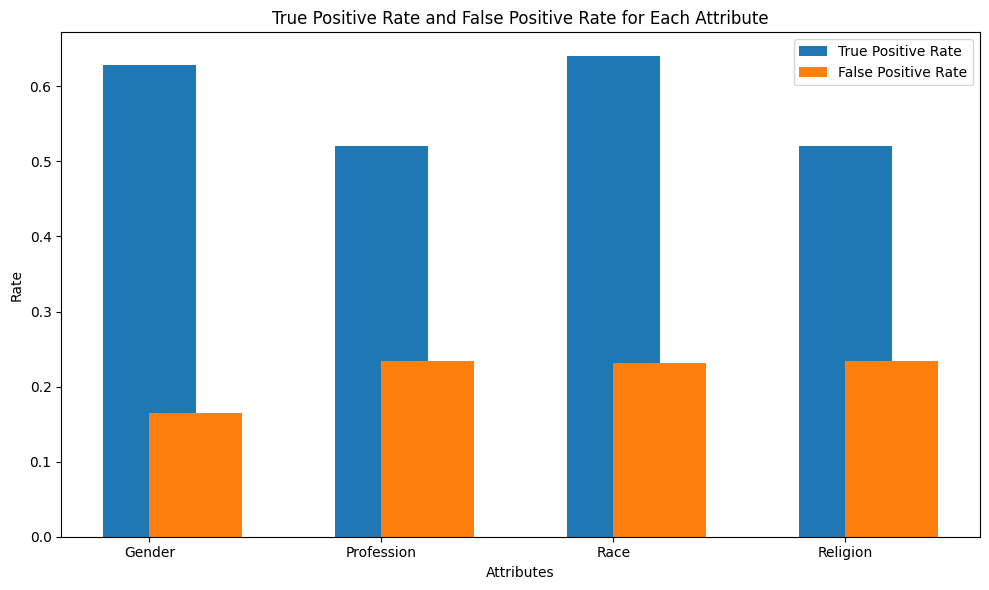

In [62]:
# Attributes and their corresponding TPR and FPR values
attributes = [ 'Gender', 'Profession', 'Race', 'Religion']
tpr_values = [0.628, 0.521, 0.640, 0.521]
fpr_values = [0.165, 0.234, 0.231, 0.234]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot TPR and FPR for each attribute
ax.bar(attributes, tpr_values, width=0.4, label='True Positive Rate', align='center')
ax.bar(attributes, fpr_values, width=0.4, label='False Positive Rate', align='edge')

# Set the title and labels
ax.set_title('True Positive Rate and False Positive Rate for Each Attribute')
ax.set_xlabel('Attributes')
ax.set_ylabel('Rate')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()